In [2]:
from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

Wine Quality


In [ ]:
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                       delimiter=';')

#Print Check
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [ ]:
def regularized_cov(X, lambda_reg):
    """
    Compute the regularized covariance matrix.

    Parameters:
    - X: Data matrix (features x samples).
    - lambda_reg: Regularization parameter.

    Returns:
    - Regularized covariance matrix.
    """
    n = X.shape[0]
    sigma = np.cov(X)
    sigma += lambda_reg * np.eye(n)
    return sigma

# Extracting data matrix X and target labels vector
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Encode labels as 0, 1, ..., C
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(qualities)

# Estimate class priors
class_priors = wine_df.groupby('quality').size().to_numpy() / len(wine_df)

# Infer number of classes
num_classes = len(class_priors)

# Calculate class means
class_means = wine_df.groupby('quality').mean().to_numpy()

# Infer number of features
num_features = class_means.shape[1]

# Calculate regularized covariance matrices for each class
cov_matrices = np.array([regularized_cov(X[labels == l].T, 1 / num_features) for l in range(num_classes)])

# Count samples per class
samples_per_class = np.array([np.sum(labels == l) for l in range(num_classes)])

print(samples_per_class)

# Store results in a dictionary
gmm = {
    'priors': class_priors,
    'm': class_means,
    'C': cov_matrices
}


[  20  163 1457 2198  880  175    5]


In [ ]:
def erm_classification(X, cost_matrix, gmm_params, num_classes):
    """
    Perform ERM classification to minimize the probability of error.

    Parameters:
    - X: Data matrix (samples x features).
    - cost_matrix: Cost matrix (num_classes x num_classes).
    - gmm_params: Dictionary containing GMM parameters ('priors', 'm', 'C').
    - num_classes: Number of classes.

    Returns:
    - Predicted class labels for each sample.
    """
    # Compute conditional likelihoods of each sample given each class (num_classes x num_samples)
    likelihoods = np.array([
        multivariate_normal.pdf(X, mean=gmm_params['m'][c], cov=gmm_params['C'][c])
        for c in range(num_classes)
    ])

    # Convert priors to a diagonal matrix (num_classes x num_classes)
    priors_diag = np.diag(gmm_params['priors'])

    # Compute the posterior probabilities (num_classes x num_samples)
    posteriors = priors_diag @ likelihoods

    # Compute the risk matrix (num_classes x num_samples)
    risk_matrix = cost_matrix @ posteriors

    # Return the class with the minimum risk for each sample
    return np.argmin(risk_matrix, axis=0)

In [ ]:
# Define cost matrix for 0-1 loss (identity matrix subtracted from ones matrix)
cost_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# Apply ERM decision rule to get predicted class labels
predicted_labels = erm_classification(X, cost_matrix, gmm, num_classes)

# Calculate confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_matrix = confusion_matrix(predicted_labels, labels)
print(conf_matrix)

# Calculate the total number of correctly classified samples
correctly_classified = np.sum(np.diag(conf_matrix))
print("Total Number of Misclassified Samples: {:d}".format(len(X) - correctly_classified))

# Estimate the probability of error
probability_error = 1 - (correctly_classified / len(X))
print("Empirically Estimated Probability of Error: {:.4f}".format(probability_error))

Confusion Matrix (rows: Predicted class, columns: True class):
[[   7    2    5   12    2    4    0]
 [   1    3    7    6    0    0    0]
 [   5  105  934  614  100   16    0]
 [   7   50  491 1339  472   79    2]
 [   0    3   19  227  303   73    3]
 [   0    0    1    0    3    3    0]
 [   0    0    0    0    0    0    0]]
Total Number of Misclassified Samples: 2309
Empirically Estimated Probability of Error: 0.4714


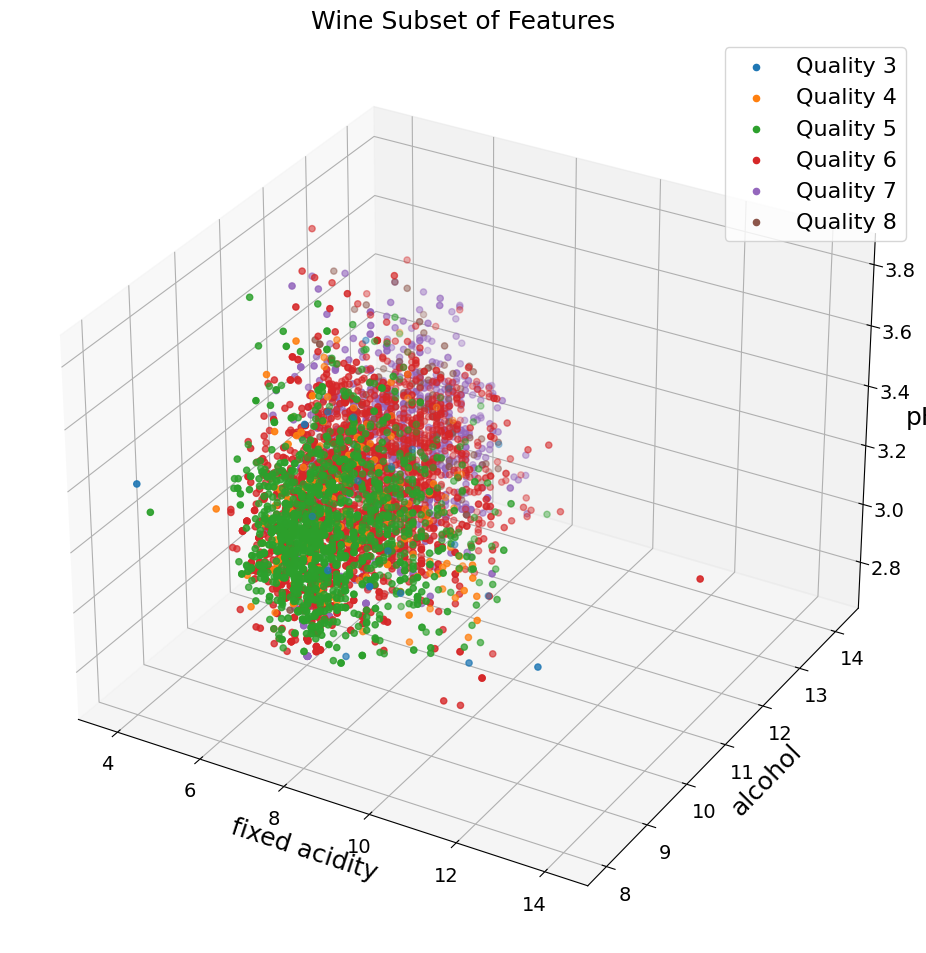

In [ ]:
# Create a figure and a 3D subplot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique quality levels and sort them
unique_qualities = np.sort(wine_df['quality'].unique())

# Plot each quality level
for q in unique_qualities:
    quality_data = wine_df[wine_df['quality'] == q]
    ax.scatter(quality_data['fixed acidity'], quality_data['alcohol'], quality_data['pH'], label=f"Quality {q}")

# Set axis labels
ax.set_xlabel("Fixed Acidity")
ax.set_ylabel("Alcohol")
ax.set_zlabel("pH")

# Optionally set equal aspect ratio for 3D plot
# ax.set_box_aspect((np.ptp(wine_df['fixed acidity']), np.ptp(wine_df['alcohol']), np.ptp(wine_df['pH'])))

# Add title and legend
plt.title("Wine Subset of Features")
plt.legend()
plt.tight_layout()
plt.show()

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


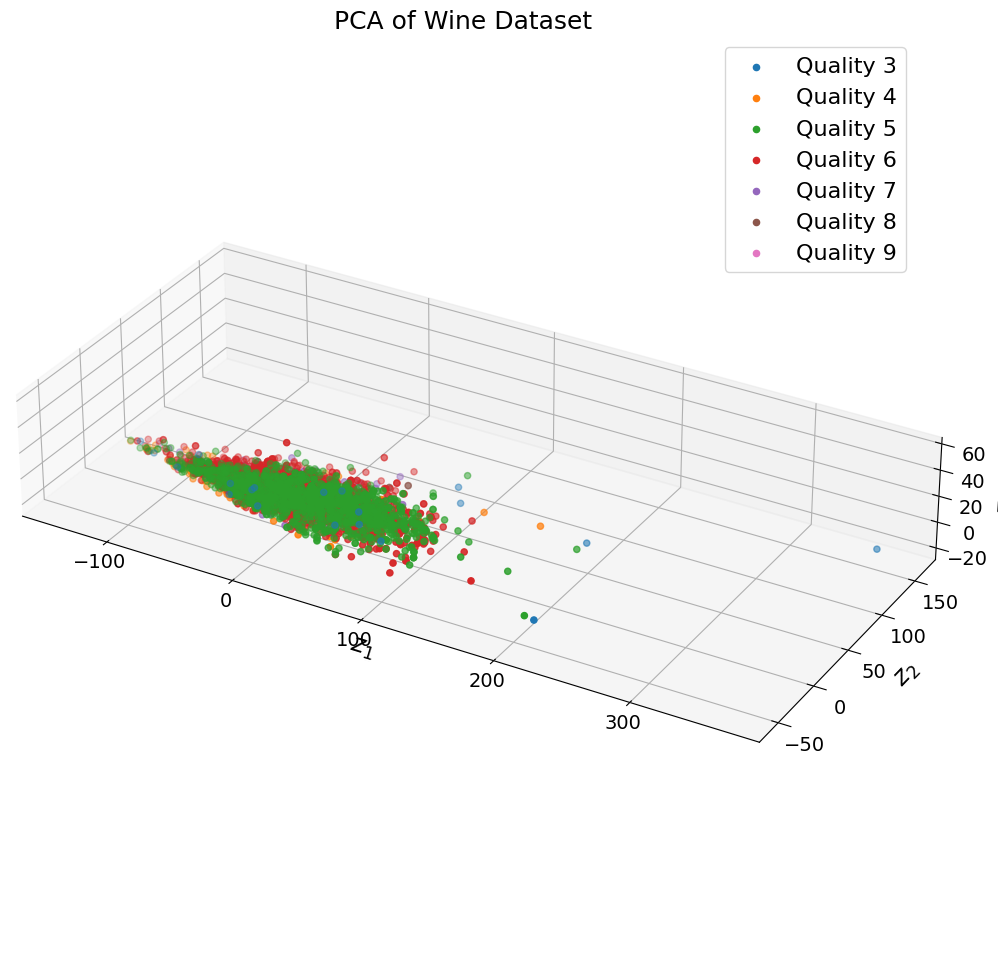

In [ ]:
# Create a figure and a 3D subplot
fig = plt.figure(figsize=(10, 10))
ax_pca = fig.add_subplot(111, projection='3d')

# Perform PCA on the dataset
pca = PCA(n_components=3)  # Number of principal components to keep
X_fit = pca.fit(X)  # Fit the PCA model to the data
Z = pca.transform(X)  # Project the data into the principal component space

# Print the explained variance ratio to check how much variance is captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

# Get unique quality levels and sort them
unique_qualities = np.sort(wine_df['quality'].unique())

# Plot each quality level in the PCA-transformed space
for q in unique_qualities:
    quality_indices = wine_df['quality'] == q
    ax_pca.scatter(Z[quality_indices, 0], Z[quality_indices, 1], Z[quality_indices, 2], label=f"Quality {q}")

# Set axis labels for the principal components
ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

# Set equal aspect ratio for the 3D plot
ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

# Add title and legend
plt.title("PCA of Wine Dataset")
plt.legend()
plt.tight_layout()
plt.show()

Human Activity Recognition


In [3]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'

# Read the zip file from the URL without writing it to disk
response = urlopen(url)
with ZipFile(BytesIO(response.read())) as har_zip:
    # Read the training and test data from the zip file
    train_df = pd.read_csv(har_zip.open('UCI HAR Dataset/train/X_train.txt'), delim_whitespace=True, header=None)
    test_df = pd.read_csv(har_zip.open('UCI HAR Dataset/test/X_test.txt'), delim_whitespace=True, header=None)

# Concatenate the training and test data into a single DataFrame
har_df = pd.concat([train_df, test_df], ignore_index=True)

#Display the data
har_df.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


Explained variance ratio:  [0.62227069 0.04772595 0.04018191]


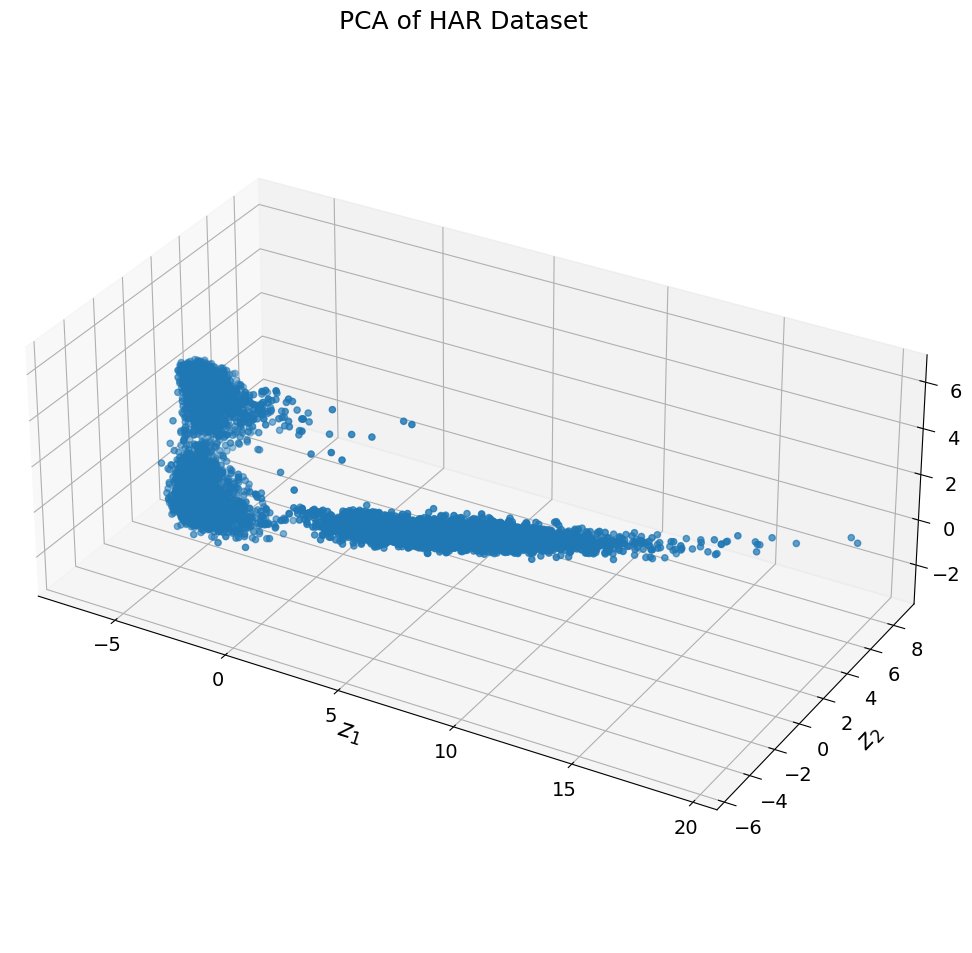

In [7]:
# Extracting data matrix X
X = har_df.to_numpy()

fig = plt.figure(figsize=(10, 10))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

ax_pca.scatter(Z[:, 0], Z[:, 1], Z[:, 2])

ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of HAR Dataset")
plt.tight_layout()
plt.show()